# COVID-19 대한민국 해외 유입 확진자 예측 모델 : LSTM

In [9]:
import torch

import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error
from pandas.plotting import register_matplotlib_converters
from torch import nn, optim

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#93D30C", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 14, 10
register_matplotlib_converters()

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

import warnings
warnings.filterwarnings('ignore')

from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)


# 1. Load Dataset

In [10]:
df = pd.read_csv('./data/total_0509.csv')
# 한국 일일확진자 변수 제거
df.drop(['Unnamed: 0'], axis=1, inplace=True)

FileNotFoundError: [Errno 2] File ./data/total_0509.csv does not exist: './data/total_0509.csv'

In [11]:
for i in list(df.columns):
    if i[0:2] == 'KR':
        print(i)

NameError: name 'df' is not defined

In [12]:
df.tail()

NameError: name 'df' is not defined

In [13]:
tmp_cols = ['EURO_conf','CHINA_conf','ASIA_conf','N_AMERICA_conf','OCEANIA_conf','TARGET']

In [ ]:
for i in tmp_cols:
    df['{}'.format(i)] = df['{}'.format(i)].diff()

In [ ]:
df.fillna(0, inplace=True)

In [ ]:
df.Date = pd.to_datetime(df.Date)

In [ ]:
df['dayofweek'] = df['Date'].dt.dayofweek
df.set_index('Date', inplace=True)

In [3]:
#df.rename(columns={'target':'TARGET'},inplace=True)

## lag 변수 생성

In [75]:
lag_amount = 3

for i in range(lag_amount):
    df['lag{}'.format(i+1)] = df['TARGET'].shift(i+1)
    
df.dropna(inplace=True)

In [76]:
df.head()

,EURO_conf,CHINA_conf,ASIA_conf,N_AMERICA_conf,OCEANIA_conf,EURO_roam,CHINA_roam,ASIA_roam,N_AMERICA_roam,OCEANIA_roam,TARGET,NEWS,dayofweek,lag1,lag2,lag3
Date,,,,,,,,,,,,,,,,
2020-01-25,1.0,486.0,2.0,0.0,0.0,1472.0,1825.0,7518.0,939.0,284.0,0.0,506.0,5,1.0,0.0,0.0
2020-01-26,0.0,669.0,5.0,4.0,4.0,1932.0,3252.0,11149.0,1056.0,310.0,1.0,552.0,6,0.0,1.0,0.0
2020-01-27,1.0,802.0,2.0,0.0,1.0,2121.0,4226.0,14079.0,1354.0,378.0,1.0,576.0,0,1.0,0.0,1.0
2020-01-28,4.0,2632.0,14.0,1.0,0.0,1888.0,2854.0,11161.0,1212.0,256.0,0.0,711.0,1,1.0,1.0,0.0
2020-01-29,1.0,578.0,4.0,0.0,1.0,1798.0,2416.0,9716.0,970.0,374.0,0.0,906.0,2,0.0,1.0,1.0


In [77]:
df.tail()

,EURO_conf,CHINA_conf,ASIA_conf,N_AMERICA_conf,OCEANIA_conf,EURO_roam,CHINA_roam,ASIA_roam,N_AMERICA_roam,OCEANIA_roam,TARGET,NEWS,dayofweek,lag1,lag2,lag3
Date,,,,,,,,,,,,,,,,
2020-05-01,9243.0,3.0,5645.0,35923.0,18.0,24.0,230.0,247.0,126.0,27.0,8.0,1104.0,4,4.0,5.0,12.0
2020-05-02,11965.0,0.0,5006.0,30661.0,23.0,77.0,90.0,254.0,174.0,71.0,8.0,732.0,5,8.0,4.0,5.0
2020-05-03,7719.0,5.0,5416.0,28079.0,23.0,48.0,130.0,248.0,104.0,9.0,10.0,821.0,6,8.0,8.0,4.0
2020-05-04,6902.0,2.0,6319.0,23788.0,24.0,51.0,94.0,238.0,95.0,21.0,8.0,1331.0,0,10.0,8.0,8.0
2020-05-05,8763.0,2.0,5515.0,25234.0,30.0,18.0,142.0,278.0,129.0,6.0,3.0,793.0,1,8.0,10.0,8.0


# Data Exploration

In [78]:
# 결측치 확인
df.isnull().sum().sum()

0

In [79]:
# 데이터 프레임 형태 확인
print("전체 데이터 shape: {}".format(df.shape))
print("target feature shape: {}".format(df['TARGET'].shape))

전체 데이터 shape: (102, 16)
target feature shape: (102,)


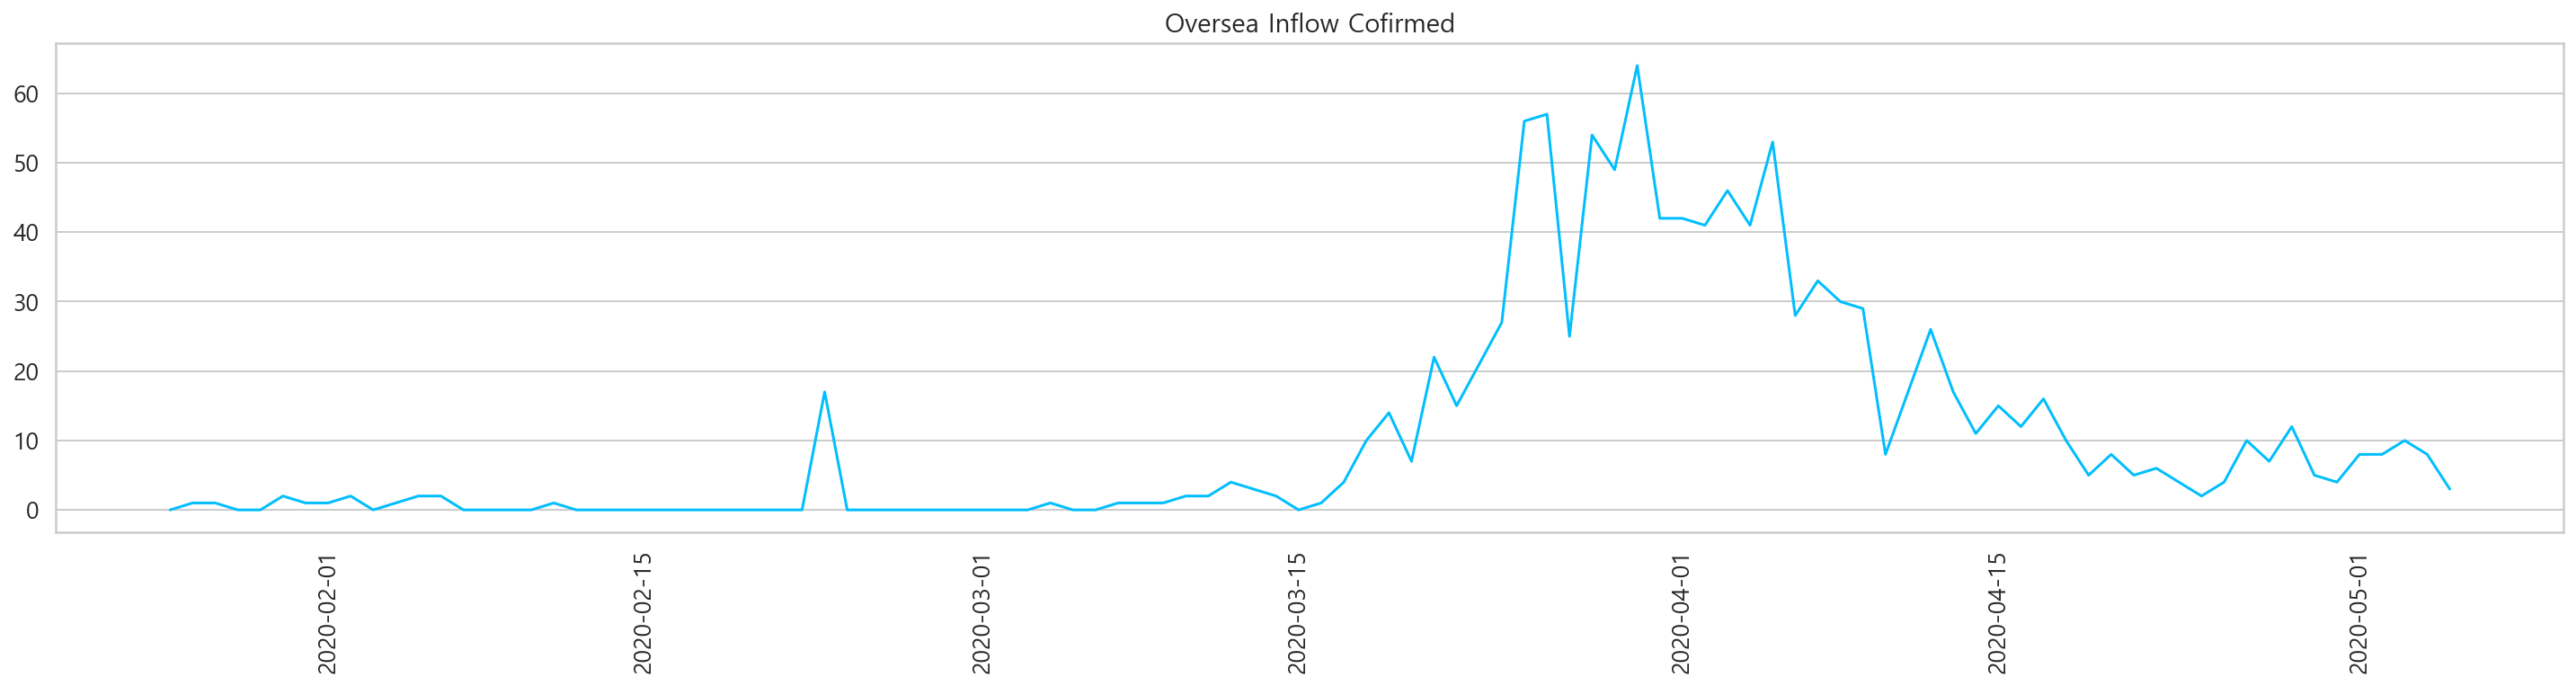

In [80]:
plt.figure(figsize=(25,5))
plt.plot(df['TARGET'])
plt.xticks(rotation=90)
plt.title("Oversea Inflow Cofirmed")
plt.grid(axis='x')

# Preprocessing

## Feature Selection

In [81]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

In [82]:
X_cols = list(df.columns)
X_cols.remove('TARGET')

In [83]:
# X변수들과 y변수 구분
X = df[X_cols]
y = df['TARGET']

In [84]:
rf = RandomForestRegressor()
rf.fit(X, y)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [85]:
param_grid = { 
    'n_estimators': [30, 110, 140],
    'min_samples_leaf' : [4, 18, 3],
    'min_samples_split' : [8, 4, 6],
}

In [86]:
# grid search
CV_rfc = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5)

In [87]:
CV_rfc

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jo

In [88]:
CV_rfc.fit(X, y)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jo

In [89]:
CV_rfc.best_params_

{'min_samples_leaf': 3, 'min_samples_split': 4, 'n_estimators': 30}

In [90]:
# parameter 설정후에 다시 진행
rf = RandomForestRegressor(n_estimators=30, min_samples_leaf=3, min_samples_split=4, max_features='auto')
rf.fit(X, y)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=3,
                      min_samples_split=4, min_weight_fraction_leaf=0.0,
                      n_estimators=30, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [91]:
# tree.feature_importances_로 설명변수 중요도 확인 및 테이블로 저장
df_importance = pd.DataFrame()
df_importance['Feature'] = list(X.columns)
df_importance['Importance'] = rf.feature_importances_

# df_feature_importance의 테이블을 중요도별로 정렬
df_importance.sort_values("Importance", ascending = False, inplace = True)
df_importance.round(3)

,Feature,Importance
4,OCEANIA_conf,0.400
0,EURO_conf,0.212
12,lag1,0.175
14,lag3,0.116
2,ASIA_conf,0.018
1,CHINA_conf,0.016
5,EURO_roam,0.015
8,N_AMERICA_roam,0.011
13,lag2,0.009
3,N_AMERICA_conf,0.008


In [97]:
df.columns.__len__()

16

In [92]:
#df_importance.to_csv('feature_importance.csv')

Text(0, 0.5, '변수')

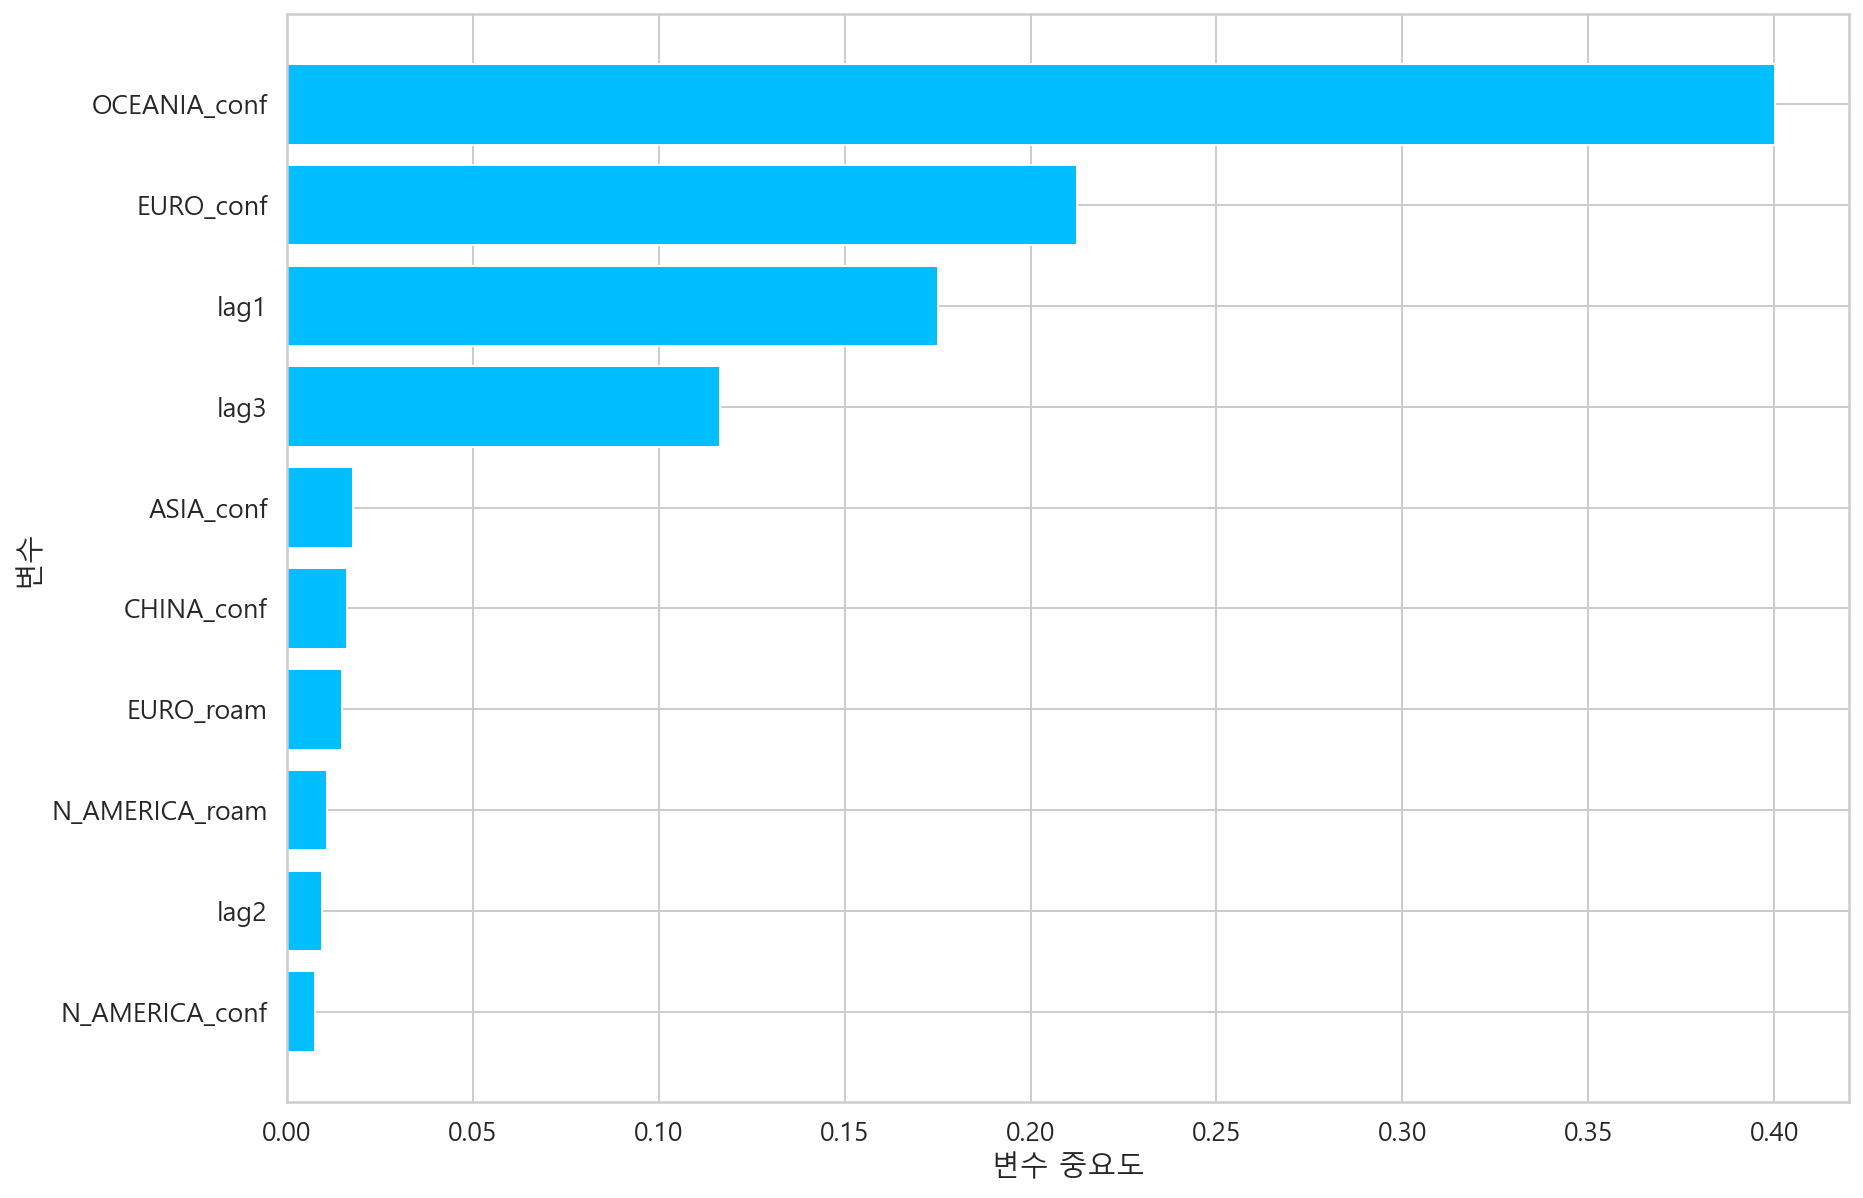

In [93]:
# 설명변수 중요도 그래
# 중요도가 높은 변수를 상위에 그림
# 상위 10개 확인
df_importance1 = df_importance.head(10)
df_importance1.sort_values("Importance", ascending = True, inplace = True)
coordinates = range(len(df_importance1))
plt.barh(y = coordinates,
        width = df_importance1['Importance'])
plt.yticks(coordinates, df_importance1['Feature'])
plt.xlabel('변수 중요도')
plt.ylabel('변수')

# LSTM Model

In [411]:
X_cols = list(df.columns)
X_cols.remove('TARGET')
new_x_cols = list(df_importance1['Feature'])

In [183]:
#X_cols = ['NZ_conf', 'DE_conf', 'lag1', 'covid_tr', 'CZ_conf', 'lag3']

In [434]:
# 테스트 데이터 수
test_data_size = 14
# X변수들과 y변수 구분

# # 앞의 40개는 지우기
# X = df[40:][X_cols]
# y = df[40:]['TARGET']

X = df[X_cols]
y = df['TARGET']

In [435]:
# MinMaxScaler을 통한 스케일링
scaler = MinMaxScaler()
# X scaler 생성
Xscaler = scaler.fit(X)
# Y scaler 생성
yscaler = scaler.fit(y.values.reshape(-1,1))

# 스케일링 적용
X = Xscaler.transform(X)
y = yscaler.transform(y.values.reshape(-1,1))

# Train, Test set split
X_train, X_test = X[:-test_data_size], X[-test_data_size:]
y_train, y_test = y[:-test_data_size].flatten(), y[-test_data_size:].flatten()

In [436]:
print("train set : ", X_train.shape)
print("test set : ", X_test.shape)

train set :  (88, 15)
test set :  (14, 15)


In [437]:
# LSTM 사용을 위한 시퀀스 데이터 형성 함수

def create_sequences1(array, seq_length):
    res = []
    if seq_length == 1:
        for i in range(len(array)):
            tmp=array[i:(i+seq_length)]
            res.append(tmp)
    else:
        for i in range(len(array)-seq_length-1):
            tmp = array[i:(i+seq_length)]
            res.append(tmp)
        
    return res

In [438]:
# 시퀀스 길이
seq_length = 1

X_train = create_sequences1(X_train, seq_length)
y_train = create_sequences1(y_train, seq_length)
X_test = create_sequences1(X_test, seq_length)
y_test = create_sequences1(y_test, seq_length)

In [439]:
# numpy -> tensor 변환
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()
X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).float()

In [440]:
print("X_train :",(X_train.shape))
print("X_test :",(X_test.shape))
print("y_train :",(y_train.shape))
print("y_test :",(y_test.shape))

X_train : torch.Size([88, 1, 15])
X_test : torch.Size([14, 1, 15])
y_train : torch.Size([88, 1])
y_test : torch.Size([14, 1])


# Building a Model

In [441]:
# 파라미터 저장할 리스트 생성
param_list = []

In [442]:
# Model Class 생성

class CoronaVirusPredictor(nn.Module):
    
    def __init__(self, n_features, n_hidden, seq_len, n_layers=2):
        super(CoronaVirusPredictor, self).__init__()
        self.n_hidden = n_hidden
        self.seq_len = seq_len
        self.n_layers = n_layers

        self.lstm = nn.LSTM(
        input_size = n_features,
        hidden_size = n_hidden,
        num_layers = n_layers,
        #dropout=0.1
        )
        
        self.linear = nn.Linear(in_features=n_hidden, out_features=1)
        
    def reset_hidden_state(self):
            self.hidden = (
                torch.zeros(self.n_layers, self.seq_len, self.n_hidden),
                torch.zeros(self.n_layers, self.seq_len, self.n_hidden))
            
    def forward(self, sequences):
        lstm_out, self.hidden = self.lstm(sequences.view(len(sequences), self.seq_len, -1), self.hidden)
        last_time_step = lstm_out.view(self.seq_len, len(sequences), self.n_hidden)[-1]
        y_pred = self.linear(last_time_step)
    
        return y_pred

## __Training__

In [443]:
def train_model(model, train_data, train_labels, test_data=None, test_labels=None, num_epochs=250, lr=1e-3):
    loss_fn = torch.nn.MSELoss()
    
    optimiser = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-3)
    num_epochs = num_epochs
    
    train_hist = np.zeros(num_epochs)
    test_hist = np.zeros(num_epochs)
    
    for t in range(num_epochs):
        model.reset_hidden_state()
        y_pred = model(X_train)
        loss = loss_fn(y_pred.float(), y_train)
        
        if test_data is not None:
            with torch.no_grad():
                y_test_pred = model(X_test)
                test_loss = loss_fn(y_test_pred.float(), y_test)
            test_hist[t] = test_loss.item()
            
            if t % 10 == 0:
                print(f'Epoch {t} train loss: {round(loss.item(),4)} test loss: {round(test_loss.item(),4)}')
        elif t % 10 == 0:
            print(f'Epoch {t} train loss: {loss.item()}')
            
        train_hist[t] = loss.item()
        optimiser.zero_grad()
        loss.backward()
        optimiser.step()
        
    return model.eval(), train_hist, test_hist

In [444]:
# Hyper-parameter 설정
n_features=X_train.shape[-1]
n_hidden=64
n_layers=4
lr=1e-4
num_epochs=250

# Training Model
model = CoronaVirusPredictor(n_features=n_features, n_hidden=n_hidden, seq_len=seq_length, n_layers=n_layers)
model, train_hist, test_hist = train_model(model, X_train, y_train, X_test, y_test, num_epochs=num_epochs, lr=lr)

Epoch 0 train loss: 0.0752 test loss: 0.0021
Epoch 10 train loss: 0.0689 test loss: 0.0023
Epoch 20 train loss: 0.0631 test loss: 0.0042
Epoch 30 train loss: 0.0571 test loss: 0.0066
Epoch 40 train loss: 0.0501 test loss: 0.0086
Epoch 50 train loss: 0.0416 test loss: 0.0118
Epoch 60 train loss: 0.032 test loss: 0.0122
Epoch 70 train loss: 0.0226 test loss: 0.0096
Epoch 80 train loss: 0.0153 test loss: 0.0051
Epoch 90 train loss: 0.0115 test loss: 0.0034
Epoch 100 train loss: 0.0096 test loss: 0.0034
Epoch 110 train loss: 0.0087 test loss: 0.0034
Epoch 120 train loss: 0.0082 test loss: 0.0033
Epoch 130 train loss: 0.008 test loss: 0.0032
Epoch 140 train loss: 0.0079 test loss: 0.0034
Epoch 150 train loss: 0.0078 test loss: 0.0035
Epoch 160 train loss: 0.0077 test loss: 0.0035
Epoch 170 train loss: 0.0077 test loss: 0.0036
Epoch 180 train loss: 0.0076 test loss: 0.0036
Epoch 190 train loss: 0.0076 test loss: 0.0037
Epoch 200 train loss: 0.0075 test loss: 0.0037
Epoch 210 train loss: 0.00

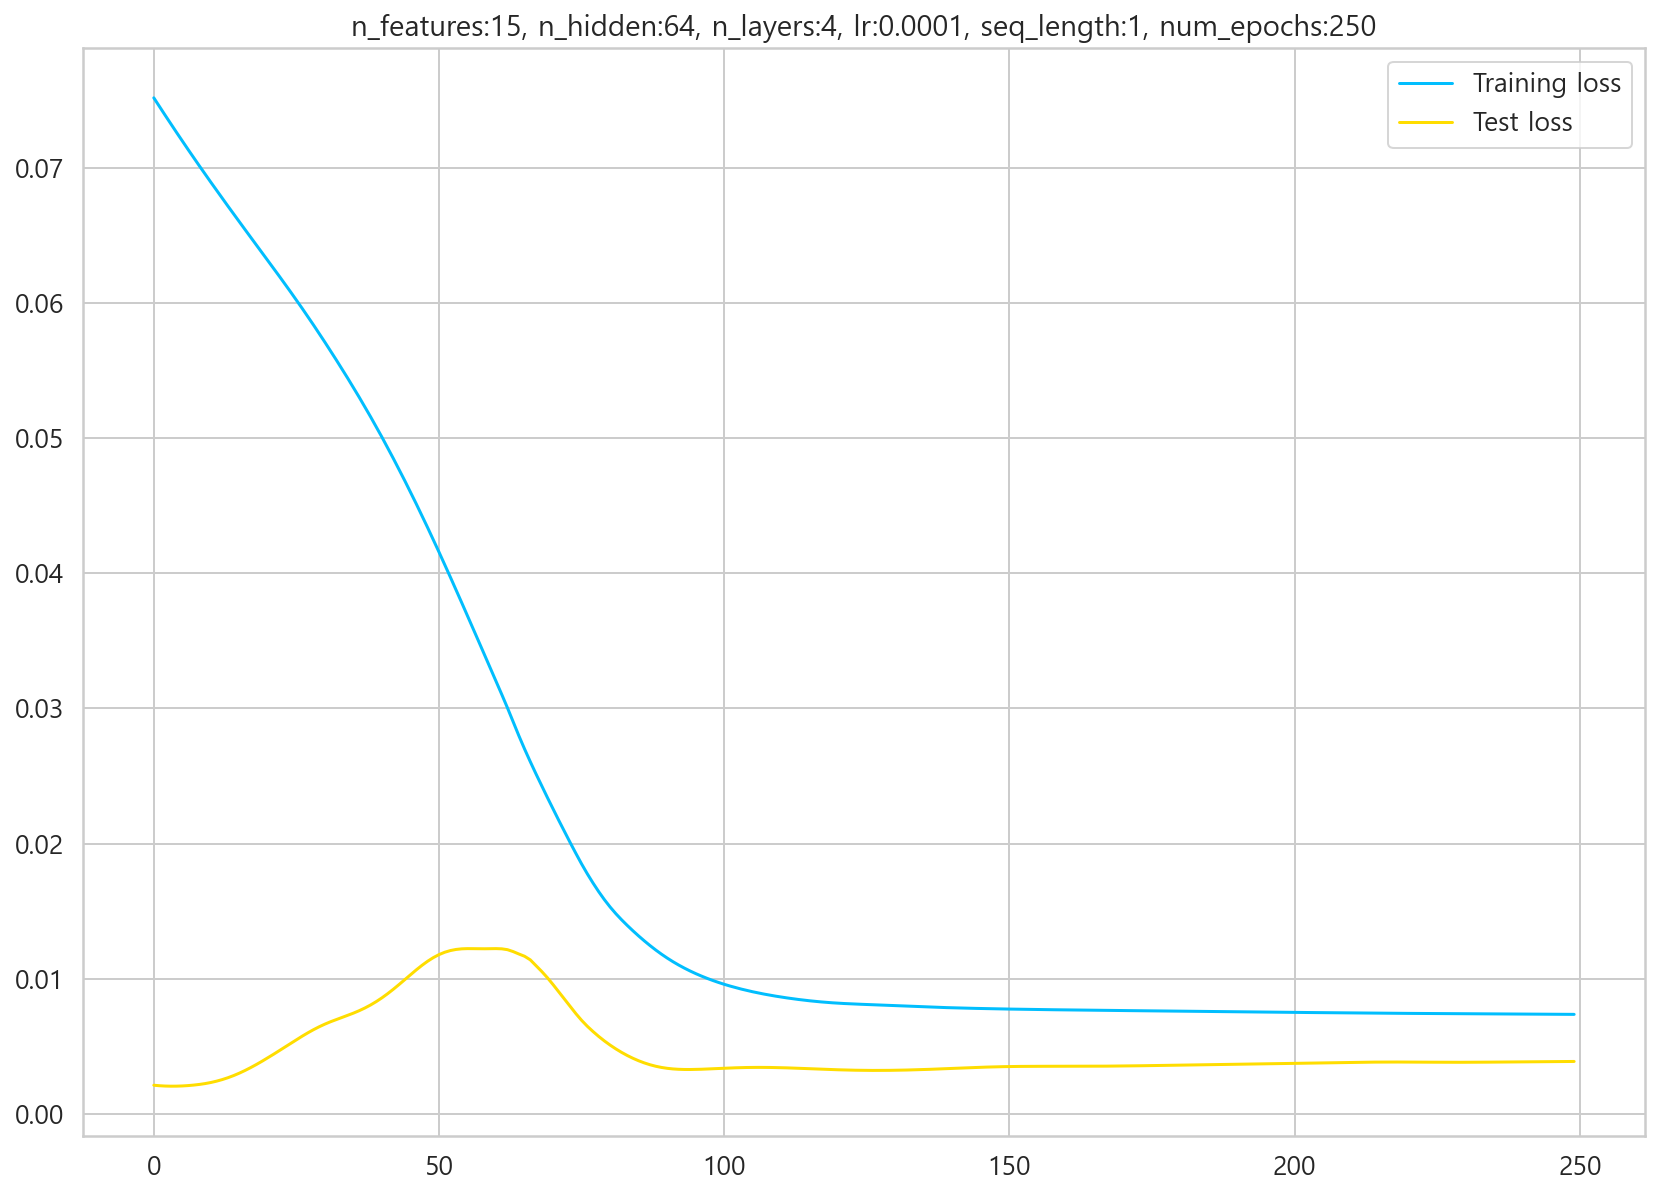

In [445]:
# plotting Loss
plt.plot(train_hist, label="Training loss")
plt.plot(test_hist, label="Test loss")
plt.title('n_features:{0}, n_hidden:{1}, n_layers:{2}, lr:{3}, seq_length:{4}, num_epochs:{5}'.format(n_features,n_hidden,n_layers,lr,seq_length,num_epochs))
plt.legend()

# Predicting daily cases

In [446]:
with torch.no_grad():
    
    preds = []
    for i in range(len(X_test)):
        test_seq = X_test[i:i+1]
        y_test_pred = model(test_seq)
        pred = torch.flatten(y_test_pred).item()
        preds.append(pred)
        new_seq = test_seq.numpy().flatten()
        new_seq = np.append(new_seq, pred)
        new_seq = new_seq[1:]
        test_seq = torch.as_tensor(new_seq).view(n_features, seq_length, 1).float()

In [447]:
# Prediction value 스케일링 역변환
pred_values = yscaler.inverse_transform(np.array(preds).reshape(-1,1))

In [448]:
pred_values_ceiled  = list(pred_values.flatten())

In [449]:
# True value 스케일링 역변환
true_values = yscaler.inverse_transform(y_test)[:, [-1]]

In [450]:
# 실제값 예측값 데이터 프레임 생성
score_table = pd.DataFrame({'True':true_values.flatten(),
                            'Pred':pred_values_ceiled})

In [451]:
score_table

,True,Pred
0,6.0,3.205916
1,4.0,3.168766
2,2.0,3.229784
3,4.0,3.256101
4,10.0,3.246388
5,7.0,3.213324
6,12.0,3.162117
7,5.0,3.113978
8,4.0,3.065122
9,8.0,3.022868


In [452]:
# validation score
MSE = mean_squared_error(score_table['True'], score_table['Pred'])
RMSE = np.sqrt(MSE)
score = 100*(1-(((score_table['Pred'] -score_table['True'])**2).sum())/((score_table['True']**2).sum()))

In [453]:
print("MSE : {0}, RMSE : {1}, SCORE : {2}".format(MSE, RMSE, score))

MSE : 19.91356687131602, RMSE : 4.462461974215133, SCORE : 60.5671943142257


In [454]:
param_list.append([n_features, n_hidden, n_layers, lr, num_epochs, MSE, RMSE, score])
param_table=pd.DataFrame(param_list,columns=['n_features', 'n_hidden', 'n_layers', 'lr', 'num_epochs', 'MSE', 'RMSE', 'score'])
param_table

,n_features,n_hidden,n_layers,lr,num_epochs,MSE,RMSE,score
0,15,64,4,0.0001,250,19.913567,4.462462,60.567194


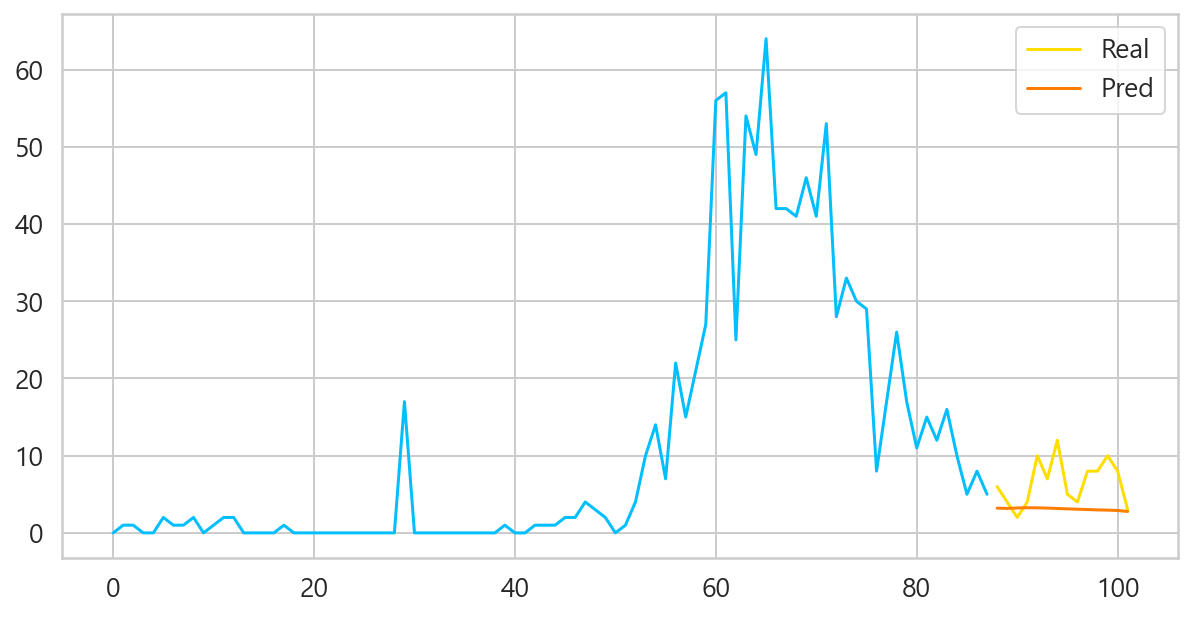

In [455]:
plt.figure(figsize=(10,5))
plt.plot(range(y_train.__len__()),yscaler.inverse_transform(y_train)[:, [-1]])
plt.plot(range(y_train.__len__(), y_train.__len__()+y_test.__len__()),true_values, label='Real')
plt.plot(range(y_train.__len__(), y_train.__len__()+y_test.__len__()),pred_values_ceiled, label='Pred')
#plt.xlim(70)
plt.legend()

In [ ]:
# 모델 저장
PATH = './models/LSTM_seq1_n_features_{0}_n_hidden_{1}_n_layers_{2}_lr_{3}_seq_length_{4}_num_epochs_{5}.pth'.format(n_features,n_hidden,n_layers,lr,seq_length,num_epochs)
torch.save(model, PATH)
# 모델 불러오기
model = torch.load(PATH)
#model.eval()

# Use all data for training

In [164]:
# X변수들과 y변수 구분
X_all = df[X_cols]
y_all = df['TARGET']

In [165]:
# MinMaxScaler을 통한 스케일링
scaler = MinMaxScaler()
# X scaler 생성
Xscaler = scaler.fit(X_all)
# Y scaler 생성
yscaler = scaler.fit(y_all.values.reshape(-1,1))

# 스케일링 적용
X_all = Xscaler.transform(X_all)
y_all = yscaler.transform(y_all.values.reshape(-1,1))
y_all = y_all.flatten()

In [166]:
y_all

array([0.      , 0.015625, 0.015625, 0.      , 0.      , 0.03125 ,
       0.015625, 0.015625, 0.03125 , 0.      , 0.015625, 0.03125 ,
       0.03125 , 0.      , 0.      , 0.      , 0.      , 0.015625,
       0.      , 0.      , 0.      , 0.      , 0.      , 0.      ,
       0.      , 0.      , 0.      , 0.      , 0.      , 0.265625,
       0.      , 0.      , 0.      , 0.      , 0.      , 0.      ,
       0.      , 0.      , 0.      , 0.015625, 0.      , 0.      ,
       0.015625, 0.015625, 0.015625, 0.03125 , 0.03125 , 0.0625  ,
       0.046875, 0.03125 , 0.      , 0.015625, 0.0625  , 0.15625 ,
       0.21875 , 0.109375, 0.34375 , 0.234375, 0.328125, 0.421875,
       0.875   , 0.890625, 0.390625, 0.84375 , 0.765625, 1.      ,
       0.65625 , 0.65625 , 0.640625, 0.71875 , 0.640625, 0.828125,
       0.4375  , 0.515625, 0.46875 , 0.453125, 0.125   , 0.265625,
       0.40625 , 0.265625, 0.171875, 0.234375, 0.1875  , 0.25    ,
       0.15625 , 0.078125, 0.125   , 0.078125, 0.09375 , 0.062

In [173]:
print("X_all : ", X_all.shape)
print("y_all : ", y_all.shape)

X_all :  torch.Size([102, 1, 15])
y_all :  torch.Size([102, 1])


In [174]:
X_all = create_sequences1(X_all, seq_length)
y_all = create_sequences1(y_all, seq_length)
X_all = torch.from_numpy(np.array(X_all)).float()
y_all = torch.from_numpy(np.array(y_all)).float()

ValueError: only one element tensors can be converted to Python scalars

In [175]:
model = CoronaVirusPredictor(
  n_features=n_features,
  n_hidden=n_hidden,
  seq_len=seq_length,
  n_layers=n_layers
)
model, train_hist, _ = train_model(model, X_all, y_all, num_epochs=200, lr=lr)

Epoch 0 train loss: 0.1371423304080963
Epoch 10 train loss: 0.12147509306669235
Epoch 20 train loss: 0.10805083066225052


KeyboardInterrupt: 

# Predicting future cases

In [170]:
DAYS_TO_PREDICT = 14
with torch.no_grad():
    test_seq = X_all[:1]
    preds = []
    for _ in range(DAYS_TO_PREDICT):
        y_test_pred = model(test_seq)
        pred = torch.flatten(y_test_pred).item()
        preds.append(pred)
        new_seq = test_seq.numpy().flatten()
        new_seq = np.append(new_seq, [pred])
        new_seq = new_seq[1:]
        #test_seq = torch.as_tensor(new_seq).view(1, seq_length, 1).float()

In [171]:
# Prediction value 스케일링 역변환
pred_values = yscaler.inverse_transform(np.array(preds).reshape(-1,1))

In [172]:
# 예측값 반올림
import math

pred_values_ceiled = list(map(lambda x: math.ceil(x), pred_values))
predicted_cases=pred_values_ceiled
predicted_cases

[-2, -2, -2, -2, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]

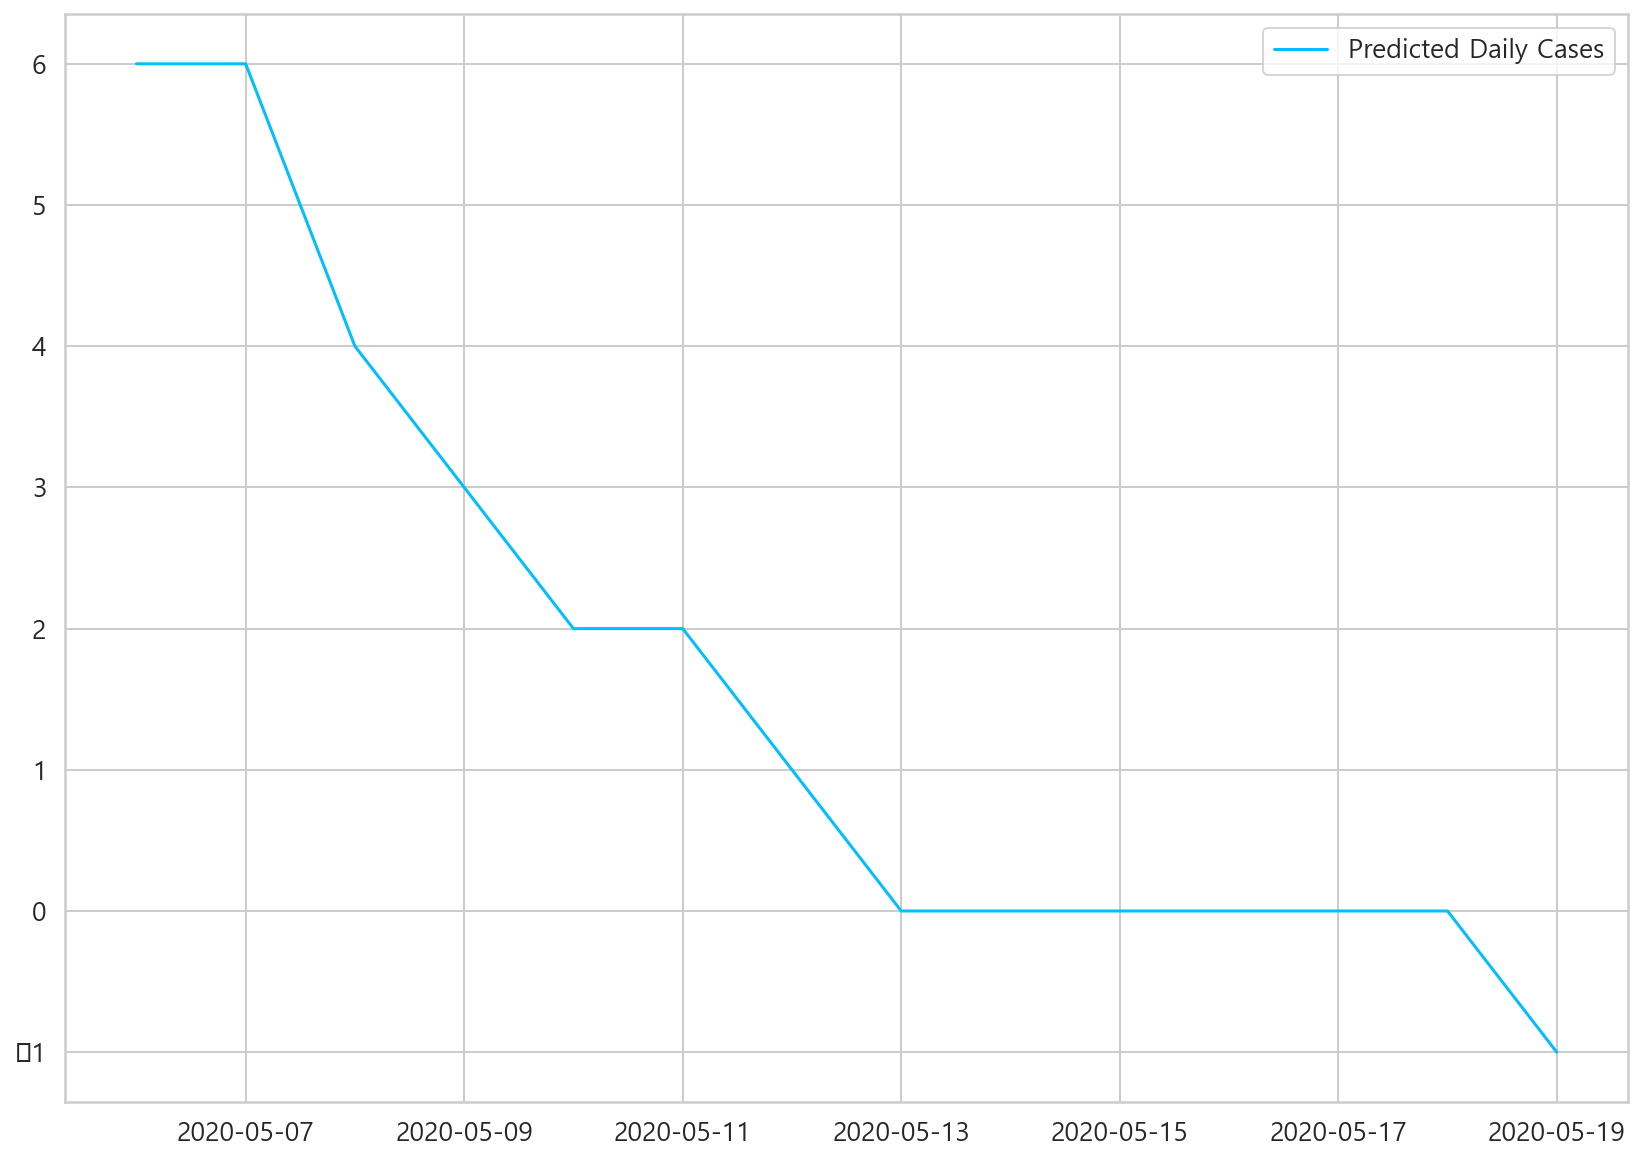

In [152]:
predicted_index = pd.date_range(
  start=df.index[-1],
  periods=DAYS_TO_PREDICT + 1,
  closed='right'
)
predicted_index = pd.to_datetime(predicted_index, format='%Y%m%d')

predicted_cases = pd.Series(
  data=predicted_cases,
  index=predicted_index
)

plt.plot(predicted_cases, label='Predicted Daily Cases')
plt.legend();

In [153]:
preds_ = pd.DataFrame(predicted_cases)
df.index = pd.to_datetime(df.index)

In [154]:
preds_

,0
2020-05-06,6
2020-05-07,6
2020-05-08,4
2020-05-09,3
2020-05-10,2
2020-05-11,2
2020-05-12,1
2020-05-13,0
2020-05-14,0
2020-05-15,0


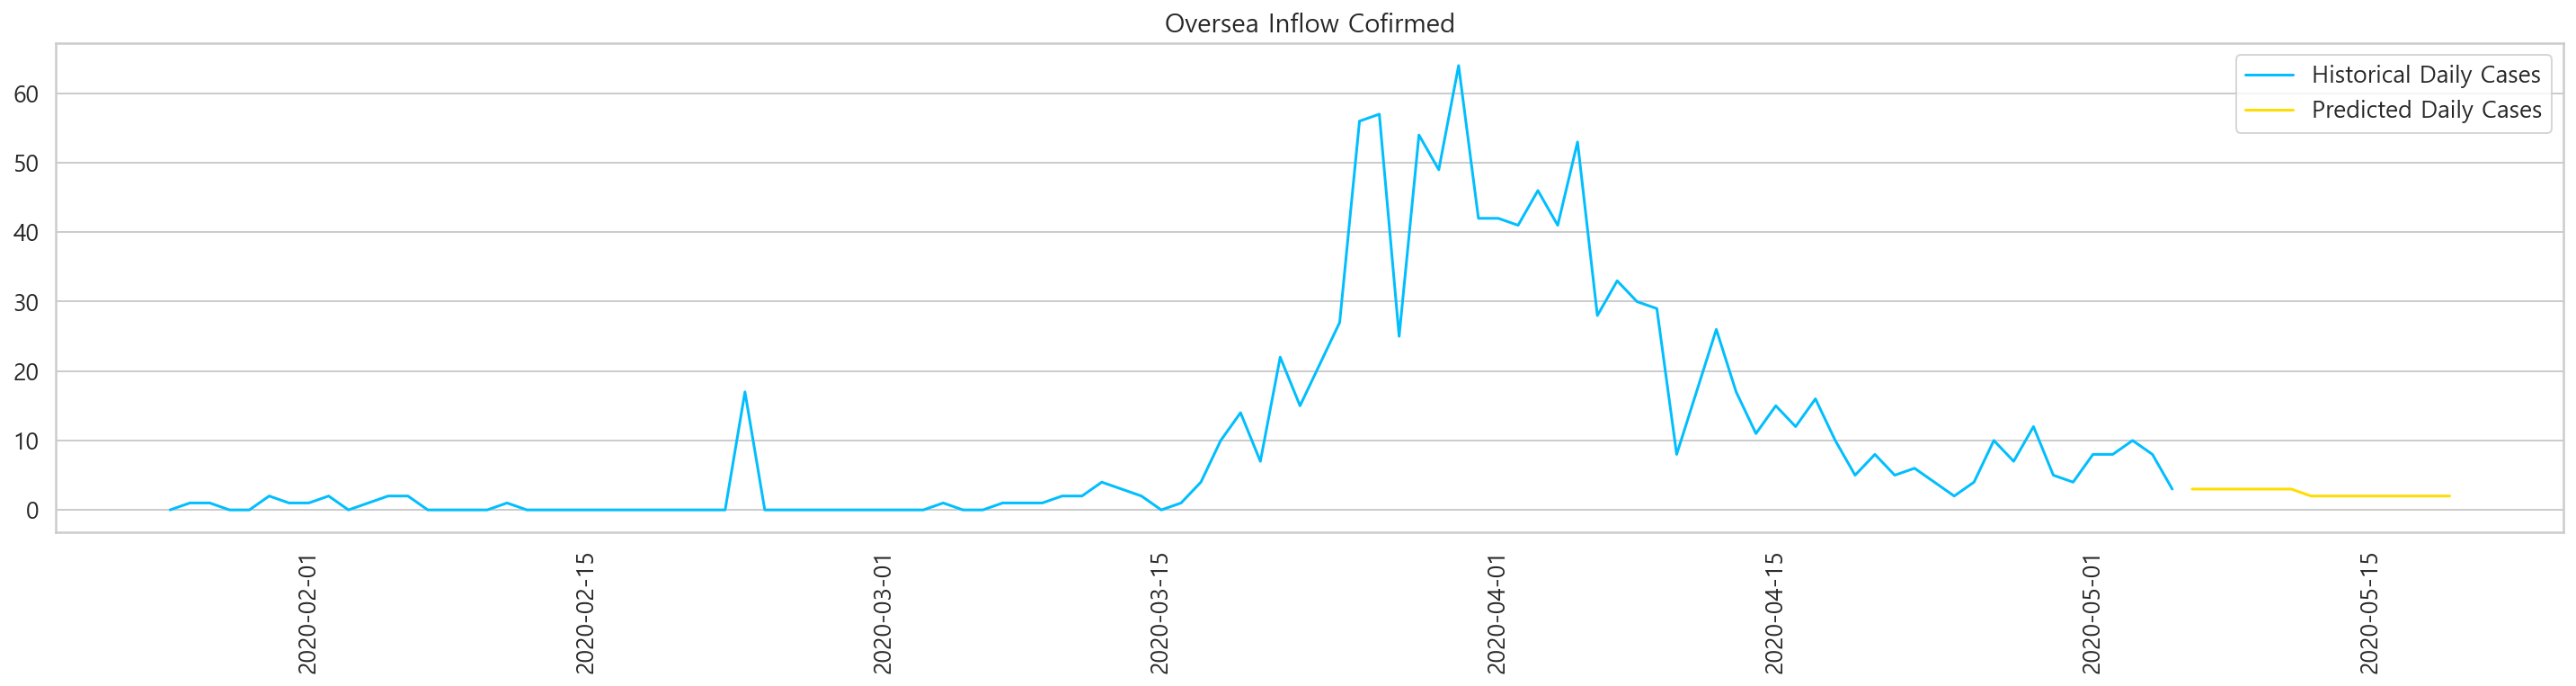

In [1667]:
plt.figure(figsize=(25,5))
plt.plot(df['TARGET'].astype(int), label='Historical Daily Cases')
plt.plot(preds_, label='Predicted Daily Cases')
plt.xticks(rotation=90)
plt.title("Oversea Inflow Cofirmed")
plt.grid(axis='x')
plt.legend();